In [4]:
import copy
from pathlib import Path
import warnings
from typing import Dict, List, Tuple, Union

import torch
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Test Dataset

In [5]:
data = pd.read_pickle('../M5_Dataset/tft_dataset.pkl')
data["month"] = data["month"].astype(str).astype("category")

special_days = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
snap_days = ['snap_CA', 'snap_TX', 'snap_WI']

data[snap_days] = data[snap_days].astype(str).astype("category")

train_dataset = data[data.d < 1912]
test_dataset = data[data.d >= 1912]

max_prediction_length = 30
max_encoder_length = 90
training_cutoff = train_dataset["d"].max() - max_prediction_length

test_encoder = train_dataset[lambda x: x.d > x.d.max() - max_encoder_length]
test_dataset = pd.concat([test_encoder, test_dataset], ignore_index=True)
test_cutoff = test_dataset["d"].max() - max_prediction_length

In [6]:
train_dataset = TimeSeriesDataSet(
    train_dataset[lambda x: x.d <= training_cutoff],
    time_idx="d",
    target="sold",
    group_ids=["Node"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Node", "store_id", "dept_id", "state_id", 'cat_id'],
    time_varying_known_categoricals=["special_days", "month", "snap_days"],
    variable_groups={"special_days": special_days, "snap_days": snap_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["d"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sold"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

test_dataset = TimeSeriesDataSet(
    test_dataset[lambda x: x.d <= test_cutoff],
    time_idx="d",
    target="sold",
    group_ids=["Node"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Node", "store_id", "dept_id", "state_id", 'cat_id'],
    time_varying_known_categoricals=["special_days", "month", "snap_days"],
    variable_groups={"special_days": special_days, "snap_days": snap_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["d"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["sold"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

# Test models

In [7]:
dirs = glob('lightning_logs/default/version_*/')
dirs.sort()
dirs

['lightning_logs/default/version_2/',
 'lightning_logs/default/version_5/',
 'lightning_logs/default/version_6/']

In [21]:
for dr in dirs[-2:-1]:
    path = glob(dr+'checkpoints/*.ckpt')
    load_tft = TemporalFusionTransformer.load_from_checkpoint(path[0])
    pred = load_tft.predict(dataloader, mode="raw")
    interpretation = load_tft.interpret_output(pred, reduction="sum")
    figures = load_tft.plot_interpretation(interpretation)

RuntimeError: torch.cat(): Sizes of tensors must match except in dimension 0. Got 90 and 89 in dimension 3 (The offending index is 11)

In [ ]:
pred.keys()

In [ ]:
pred['encoder_variables'].shape

In [ ]:
pred['decoder_variables'].shape

In [ ]:
pred['static_variables'].shape

In [ ]:
pred['attention'].shape

In [ ]:
test = pred['attention'][0].clone().detach()

In [ ]:
test.shape

In [ ]:
a = test.mean(dim=1)

In [ ]:
a.shape

In [ ]:
a

In [ ]:
a[5].shape

In [ ]:
def plot_persistent_temporal_pattern(attention_matrix, horizon):
    attention_matrix = attention_matrix.mean(dim=0)
    attention_matrix = attention_matrix.mean(dim=1)
    return attention_matrix

In [ ]:
plot_persistent_temporal_pattern

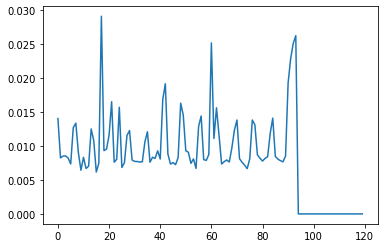

In [40]:
plt.plot(b_mean[4])

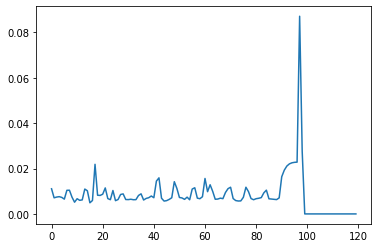

In [41]:
plt.plot(b_mean[9])

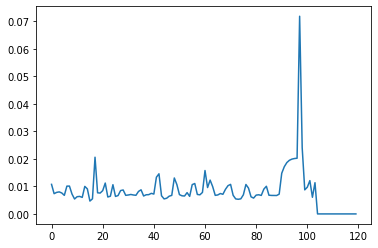

In [42]:
plt.plot(b_mean[14])

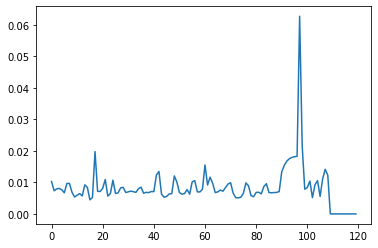

In [43]:
plt.plot(b_mean[19])

In [35]:
b = pred['attention'].clone().detach()

In [36]:
b_mean = b.mean(dim=0)

In [38]:
b_mean = b_mean.mean(dim=1)

In [39]:
b_mean.shape

torch.Size([30, 120])

In [44]:
c = pred['attention'].clone().detach()

In [45]:
c.shape

torch.Size([70, 30, 4, 120])

In [46]:
c_mean = c.mean(dim=2)

In [47]:
c_mean.shape

torch.Size([70, 30, 120])

In [48]:
d = c_mean[:,0,:]

In [49]:
d.shape

torch.Size([70, 120])

In [85]:
np.percentile(d[:,0], 90)

0.023939029686152937

In [86]:
np.percentile(d[:,0], 50)

0.015122189652174711

In [87]:
np.percentile(d[:,0], 10)

0.007428180798888207

In [103]:
q_10 = []
q_50 = []
q_90 = []

for i in range(120):
    q_10.append(np.percentile(d[:,i], 10))
    q_50.append(np.percentile(d[:,i], 50))
    q_90.append(np.percentile(d[:,i], 90))

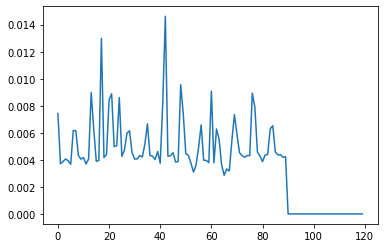

In [96]:
plt.plot(q_10)

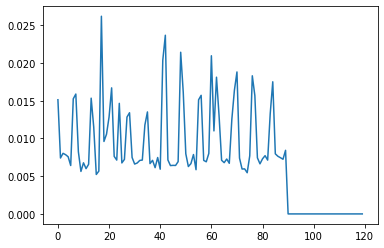

In [97]:
plt.plot(q_50)

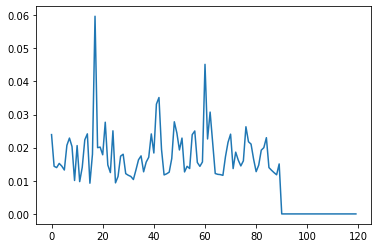

In [98]:
plt.plot(q_90)

In [20]:
dataloader = test_dataset.to_dataloader(train=False, batch_size=128, num_workers=8, shuffle=True)

In [22]:
pred = load_tft.predict(dataloader, mode="raw")

RuntimeError: torch.cat(): Sizes of tensors must match except in dimension 0. Got 90 and 89 in dimension 3 (The offending index is 3)

In [109]:
pred['attention'].shape

torch.Size([133700, 30, 4, 120])

In [110]:
k_pq = pred['attention'].clone().detach()

In [111]:
k_pq = k_pq.mean(dim=2)

In [112]:
k_pq = k_pq.mean(dim=0)

In [113]:
k_pq.shape

torch.Size([30, 120])

In [114]:
k_pq

tensor([[0.0131, 0.0124, 0.0116,  ..., 0.0000, 0.0000, 0.0000],
        [0.0128, 0.0122, 0.0113,  ..., 0.0000, 0.0000, 0.0000],
        [0.0125, 0.0119, 0.0110,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0087, 0.0082, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
        [0.0086, 0.0081, 0.0077,  ..., 0.0139, 0.0000, 0.0000],
        [0.0084, 0.0080, 0.0075,  ..., 0.0135, 0.0136, 0.0000]])

In [115]:
133700/70

1910.0